In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, mean_squared_error
from sklearn.metrics import classification_report, precision_score, recall_score, plot_precision_recall_curve

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

# Содержание<a name="0"></a>

1. [Когда и целого леса мало](#1)
2. [AdaBoost](#2)
3. [Градиентный бустинг](#3)
4. [Бустинг. Практика](#4)
5. [Стекинг](#5)
6. [Стекинг. Практика](#6)

---

# Когда и целого леса мало<a name="1"></a>

В прошлом модуле мы узнали об ансамблировании моделей. Одним из представителей такого подхода является случайный лес.

<b><span style="color:green">Случайный лес</span></b>  — это композиция глубоких деревьев, которые строятся независимо друг от друга.

Такой подход имеет следующую проблему: обучение глубоких деревьев требует очень много вычислительных ресурсов, особенно в случае большой выборки или большого числа признаков.

Если ограничить глубину решающих деревьев в случайном лесе, то они уже не смогут улавливать сложные закономерности в данных. Это приведёт к тому, что сдвиг (*bias*) будет слишком большим.

### <span style="color:green">ПРИМЕР

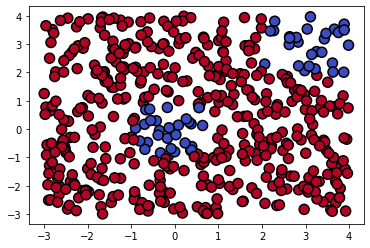

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

RANDOM_SEED = 139

def get_labels(data):
    labels = []
    for idx, item in enumerate(data):
        if item[0]**2 + item[1]**2 < 1:
            labels.append(0)
        elif item[0] > 2 and item[1] > 2:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels)

N = 500
train_data = 7 * np.random.random_sample((N,2)) - np.array([3,3])

train_labels = get_labels(train_data)

# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

shallow_rf = RandomForestClassifier(n_estimators=5, max_depth=3, n_jobs=-1, 
                                    random_state=RANDOM_SEED)
deep_rf = RandomForestClassifier(n_estimators=5, max_depth=6, n_jobs=-1, 
                                 random_state=RANDOM_SEED)

# training the tree
shallow_rf.fit(train_data, train_labels)
deep_rf.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted_shallow = shallow_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
predicted_deep = deep_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);

Text(0.5, 1.0, 'Deep Random Forest')

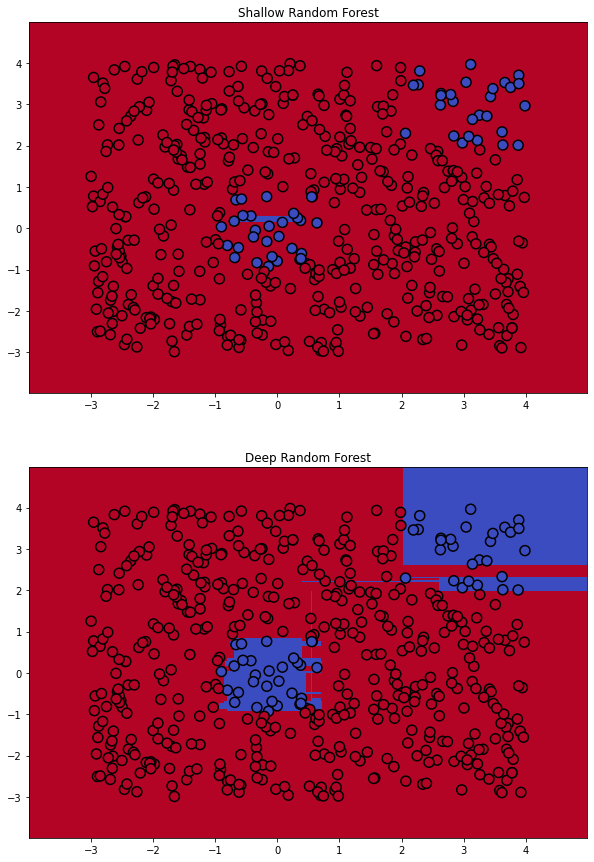

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(10,15))

ax[0].pcolormesh(xx, yy, predicted_shallow, cmap='coolwarm')
ax[0].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[0].set_title('Shallow Random Forest')

ax[1].pcolormesh(xx, yy, predicted_deep, cmap='coolwarm')
ax[1].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[1].set_title('Deep Random Forest')

### ЗАДАЧИ

Как можно заметить, на первой картинке модель, сохраненная в переменную predicted_shallow, недообучается — выделяет не все синие точки на графике. После увеличения глубины в модели *predicted_deep* на графике практически все наблюдения отмечаются правильным классом. Как будет выглядеть график, если мы еще больше увеличим глубину (например, до 100)?

Text(0.5, 1.0, 'Deeper Random Forest')

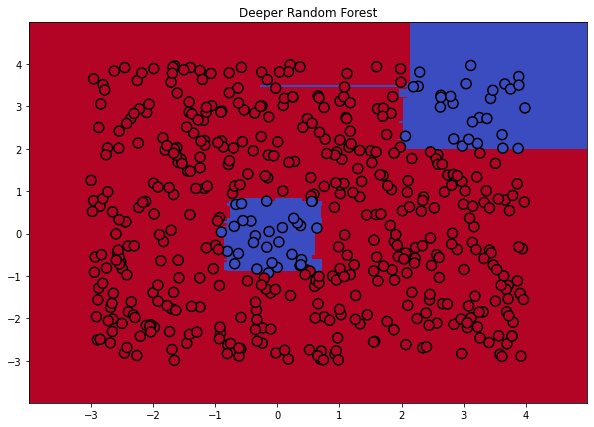

In [8]:
deeper_rf = RandomForestClassifier(n_estimators=5, max_depth=100, n_jobs=-1, 
                                 random_state=RANDOM_SEED)
deeper_rf.fit(train_data, train_labels)
predicted_deeper = deeper_rf.predict(np.c_[xx.ravel(), 
                                           yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(10,7))
plt.pcolormesh(xx, yy, predicted_deeper, cmap='coolwarm')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
plt.title('Deeper Random Forest')

<b><span style="color:green">Вторая проблема</span></b> со случайным лесом состоит в том, что процесс построения деревьев является ненаправленным: каждое следующее дерево в композиции никак не зависит от предыдущих. Из-за этого для решения сложных задач необходимо огромное количество деревьев.

[К содержанию](#0)

---

# AdaBoost<a name="2"></a>

### <span style="color:green">ПРИМЕР

*AdaBoost* — итеративный алгоритм построения ансамбля. На каждой новой итерации строится дерево решений, корректирующее ответы всех предыдущих. Будем пробовать на каждой итерации разделить данные деревом глубины 1 (так называемым <b><span style="color:green">пнём</span></b>). На первых двух итерациях мы увидим следующую картинку:

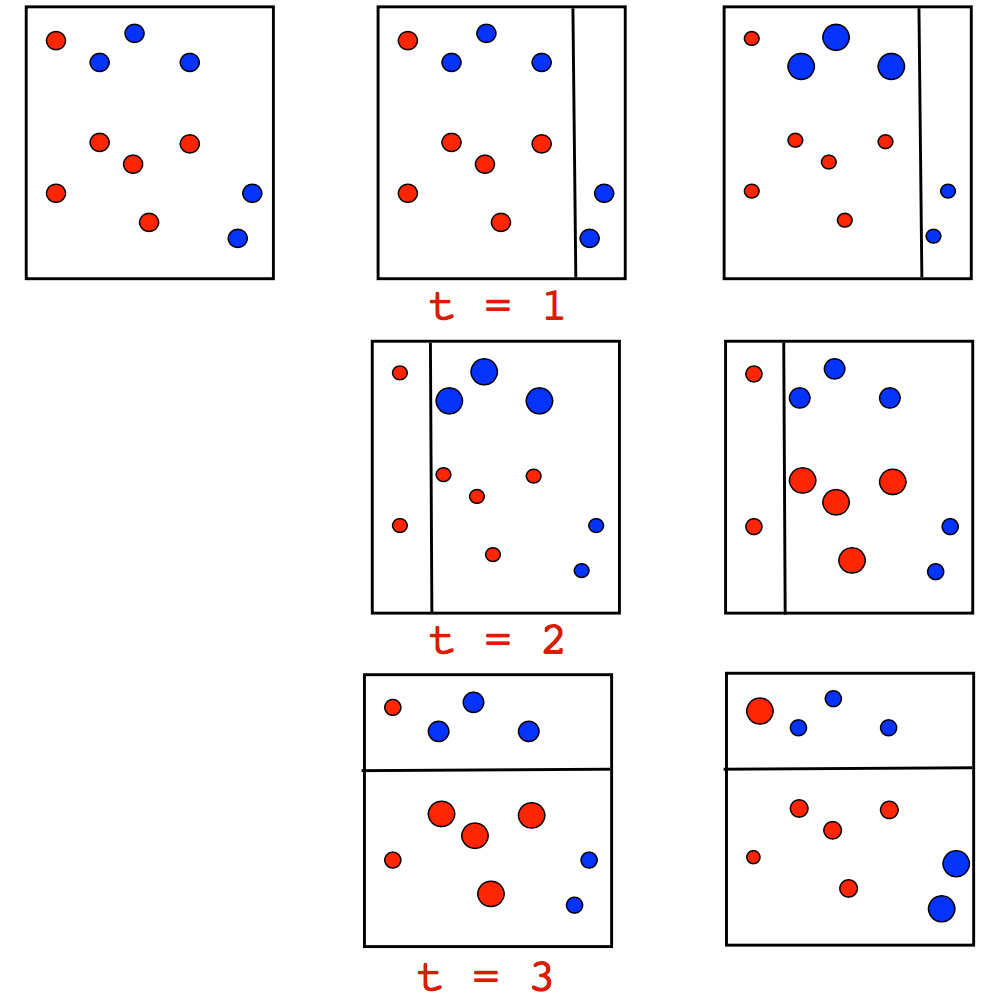

<b><span style="color:green">Размер точки</span></b> соответствует полученному ей весу за ошибочное предсказание. Мы видим, как на каждой итерации эти веса растут — пни не могут в одиночку справиться с такой задачей. Однако, когда мы произведём взвешенное голосование ранее построенных пней, мы получим искомое нами разделение:

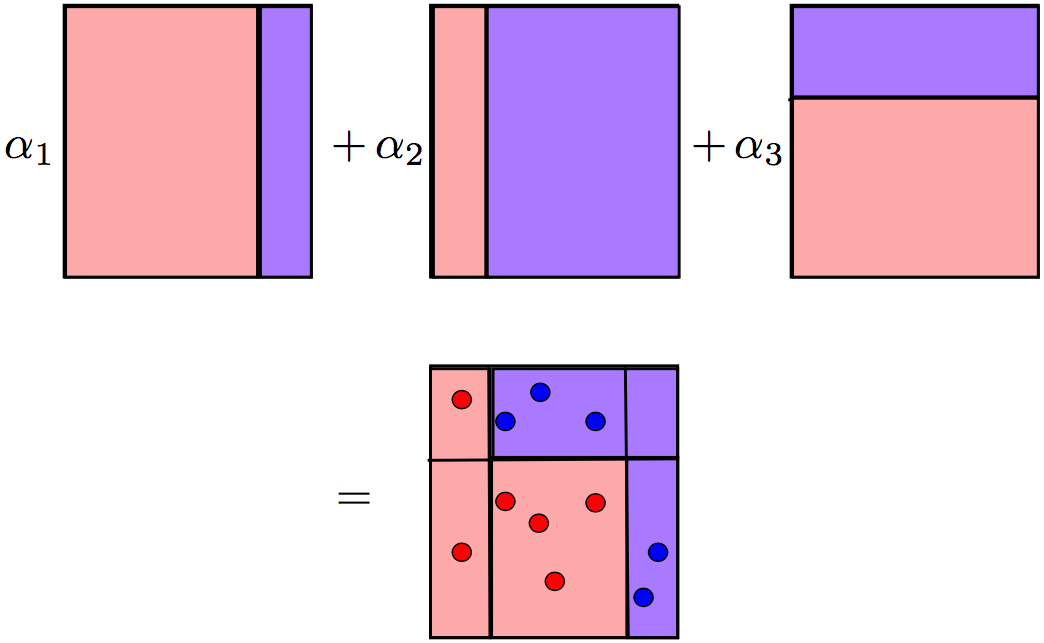

### <span style="color:green">АЛГОРИТМ

Первый ансамбль в этом разделе, который мы рассмотрим, называется *AdaBoost* (*Adaptive Boosting*). Бустинг позволяет из большого количества относительно слабых и простых моделей получить одну сильную. В нашем случае будут рассматриваться деревья решений ограниченной глубины.  

Алгоритм построение *AdaBoost*:

1. Инициализируем веса объектов $w_j = \frac{1}{N}, \, j=1,2,\dots,N$  
    
2. Для всех $i$ от 1 до T:

    1) Строим классификатор $b_i(x)$, используя веса $w_j$.

    2) Вычисляем ошибку  
    
    $err_i = {\sum\limits_{j=1}^{N}w_j[y_j \neq b_i(x_j)]}$

    3) Вычисляем вес нового алгоритма  
    
    $c_i = \frac{1}{2} \log{\frac{1-err_i}{err_i}}$, где $\frac{1}{2}$ = *learning_rate*

    4) Получаем новые веса объектов  
    
    $w_j \leftarrow w_j \cdot exp\left( c_i [y_j \neq b_i(x_j)]\right), \, j = 1, \dots, N.$

    5) Нормируем веса объектов  
    
    $w_j \leftarrow \frac{w_j}{\sum\limits_{j=1}^{N}w_j}.$

3. Группируем полученные модели: $a_T(x) = sign\left[\sum\limits_{i=1}^{T}c_i b_i(x)\right]$

>### <span style="color:green">ДОСТОИНСТВА
>
>* <span style="color:green">Алгоритм прост.
>* <span style="color:green">Накладные расходы бустинга минимальны. Время построения определяется временем построения базовых моделей.
>* <span style="color:green">Показывает хорошую обобщающую способность.
>* <span style="color:green">Имеет возможность идентификации шумовых объектов.

>### <span style="color:red">НЕДОСТАТКИ  
>
>* <span style="color:red">Жадное добавление алгоритмов приводит к неоптимальности композиции.
>* <span style="color:red">Склонен к переобучению при наличии шума в данных (опять же из-за экспоненциальной функции потерь).
>* <span style="color:red">Переобучается при «малом» количестве данных.

[К содержанию](#0)

---

# Градиентный бустинг<a name="3"></a>

Теперь рассмотрим другой вид бустинга, точнее его обобщение. Со временем после создания *AdaBoost* исследователям удалось создать более полную модель бустинга, которая называется <b><span style="color:green">Gradient Boosting</span></b>.  

Принцип такой же, как в *AdaBoost*: каждый новый алгоритм улучшает композицию построенных ранее. Рассмотрим, как строится эта композиция.  

Во-первых, определим функцию $L(y,z)$, где $y$ — истинный ответ, $z$ — прогноз алгоритма на некотором объекте. Это общий вид функции потерь, которую мы собираемся оптимизировать с помощью бустинга. Примерами возможных функций потерь являются:  

* среднеквадратичная ошибка (в задаче регрессии):  

$$L(y,z) = (y-z)^2,$$

* логистическая функция потерь (в задаче классификации):  

$$L(y,z) = \log(1+\exp(-yz)).$$

Пусть к некоторому моменту обучены $T-1$ алгоритмов $b_1(x), \dots, b_{T-1}(x)$, то есть композиция имеет вид: $a_{T-1}(x) = \sum\limits_{i=1}^{T-1}b_i(x)$.

Теперь к текущей композиции добавляется ещё один алгоритм $b_T(x)$. Этот алгоритм обучается так, чтобы как можно сильнее уменьшить ошибку композиции на обучающей выборке: $\sum\limits_{j=1}^{N}L(y_j, a_{T-1}(x_j) + b(x_j)) \rightarrow \min\limits_{b}$. 

Для того чтобы найти $b$, минимизирующее функционал, задачу разбивают на две подзадачи. Сначала определим, какие значения $s_1, \dots, s_N$ должен принимать алгоритм $b_T(x_j) = s_j$, чтобы на объектах обучающей выборки ошибка была минимальной. Формально это можно представить так:

$$F(s) = \sum\limits_{j=1}^{N}L(y_j, a_{T-1}(x_j) + s_j) \rightarrow \min\limits_{s},$$

где $s=(s_1, \dots, s_N)$.

Иными словами, необходимо найти такой вектор сдвигов $s$, который будет минимизировать функцию $F(s)$.

Поскольку направление наискорейшего убывания функции задаётся направлением антиградиента, его можно принять в качестве вектора $s$:  

$$s = - \nabla F = \begin{bmatrix} -L_z^{'}(y_1, a_{T-1}(x_1)) \\ -L_z^{'}(y_2, a_{T-1}(x_2)) \\ \vdots \\ -L_z^{'}(y_N, a_{T-1}(x_N)) \end{bmatrix}.$$

Компоненты вектора сдвигов $s$ фактически являются теми значениями, которые на объектах обучающей выборки должен принимать новый алгоритм $b_T(x)$, чтобы минимизировать ошибку строящейся композиции.

Второй этап — построение такого алгоритма $b_T(x)$. При условии, что мы уже нашли, задача построения алгоритма $b_T$ становится классической задачей на размеченных данных, ${(x_j,s_j)}_{j=1}^{N}$ — обучающая выборка, и используется, например, квадратичная функция ошибки: $b_T(x) = arg\min_{b} \frac{1}{T} \sum\limits_{j=1}^{N}(b(x_j)-s_j)^2.$  

Следует обратить особое внимание на то, что информация об исходной функции потерь $L(y, z)$, которая не обязательно является квадратичной, содержится в выражении для вектора оптимального сдвига $s$. Поэтому для большинства задач $b_T(x)$ находится, как решение задачи регрессии, используя квадратичную функцию потерь.

### <span style="color:green">АЛГОРИТМ

Запишем последовательность шагов, которую можно запрограммировать:

1. Инициализируем композицию: $a_0(x) = b_0(x)$, т. е. добавляем первый базовый алгоритм. Например, можно использовать:

    * алгоритм $b_0(x) = 0$, который всегда возвращает ноль (в задаче регрессии);
    * более сложный $b_0(x) = \frac{1}{N}\sum\limits_{j=1}^{N}y_i$, который возвращает средний истинный ответ по всем элементам обучающей выборки (в задаче регрессии);
    * алгоритм $b_0(x) = \arg\max\limits_{y \in Y}\sum\limits_{j=1}^{N}[y_i=y]$, который всегда возвращает метку самого распространенного класса в обучающей выборке (в задаче классификации).  
    
2. Итеративно повторяем следующие три шага:

    1) Вычисляем вектор сдвига

    $$s = - \nabla F = \begin{align} \begin{bmatrix} -L_z^{'}(y_1, a_{T-1}(x_1)) \\ -L_z^{'}(y_2, a_{T-1}(x_2)) \\ \vdots \\ -L_z^{'}(y_N, a_{T-1}(x_N)) \end{bmatrix} \end{align}$$

    2) Строим очередной базовый алгоритм

    $$b_T(x) = arg\min_{b} \frac{1}{T} \sum\limits_{j=1}^{N}(b(x_j)-s_j)^2.$$
    
    3) Добавляем $b_T(x)$ в композицию
    
    $$a_{T}(x) = \sum\limits_{i=1}^{T}b_i(x).$$
    
3. Если выполнен критерий останова, то останавливаем итеративный процесс.   

<b><span style="color:green">Борьба с переобучением

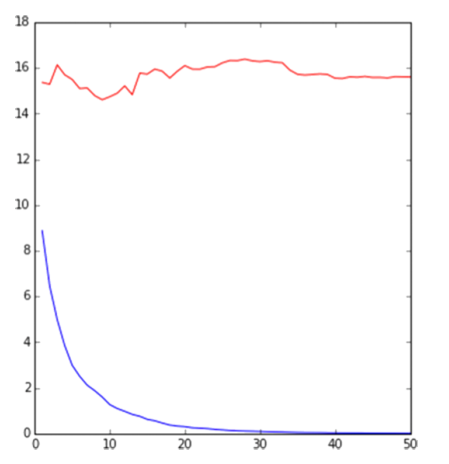 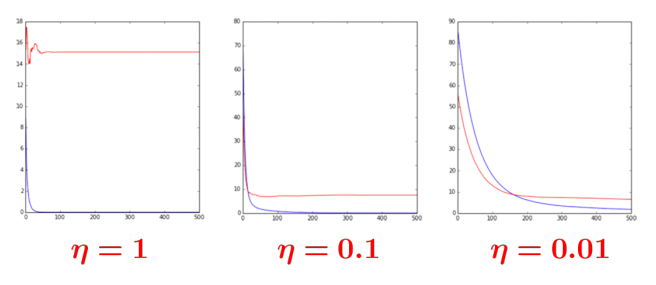

[К содержанию](#0)

---

# Бустинг. Практика<a name="4"></a>

Для решения первого задания урока сначала подготовим данные. Выкачаем набор данных, в котором будет прогнозировать, является ли письмо спамом.

Сделаем это следующим кодом:

In [10]:
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')
df.head()

,Unnamed: 0,crl.tot,dollar,bang,money,n000,make,yesno
0,1,278,0.000,0.778,0.00,0.00,0.00,y
1,2,1028,0.180,0.372,0.43,0.43,0.21,y
2,3,2259,0.184,0.276,0.06,1.16,0.06,y
3,4,191,0.000,0.137,0.00,0.00,0.00,y
4,5,191,0.000,0.135,0.00,0.00,0.00,y


Из столбца yesno сделайте столбец *spam*, где 1 соответствует значению *y* (является спамом), а 0 – *n* (не является спамом). Удалите первый столбец (с индексом) и столбец _"yesno"_.

In [11]:
df['spam'] = df['yesno'].apply(lambda x: 1 if x == 'y' else 0)

In [12]:
df = df.drop(['Unnamed: 0', 'yesno'], axis=1)

У Вас остается шесть столбцов-признаков и один столбец spam, который является нашей целевой переменной. Разделим их на X и у.

In [24]:
X = df.drop(['spam'], axis=1)
y = df['spam']

Теперь мы хотим создать новые признаки путем попарного перемножения уже имеющихся друг на друга. 

Комбинации признаков должны иметь вид "__признак1_признак2__".

Сколько получится признаков после преобразования (включая те шесть, которые были в исходных данных)?

In [25]:
columns = X.columns
for i in range(len(columns)):
    if i<len(columns):
        for j in range(i+1,len(columns)):
            col = columns[i] + '_' + columns[j]
            X[col] = X[columns[i]] * X[columns[j]]

In [27]:
len(X.columns)

21

Разделим получившися данные на обучающую и тестовую выборки в соотношение 80:20. Обучите модель *GradientBoostingClassifier* (из библиотеки *sklearn*) с параметрами по умолчанию (на момент создания урока это <code>learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features=None</code>).

Во всех методах, где присутствует случайность, укажите <code>random_state=42</code>.

Это будет наш *baseline*. Укажите точность $accuracy$ на тестовой выборке (параметр <code>score</code>), округлив до третьего знака после точки-разделителя.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=42)

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)

In [30]:
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)

In [31]:
acc = accuracy_score(y_test, gbc_pred)
print(round(acc, 3))

0.865


Воспользуйтесь методом *feature_importances_*. С его помощью вы можете оценить вклад каждого признака в обучение модели. Постройте столбчатую диаграмму, где по горизонтали указаны названия признаков, а по вертикали их важность. Укажите третий по важности признак.

<AxesSubplot:>

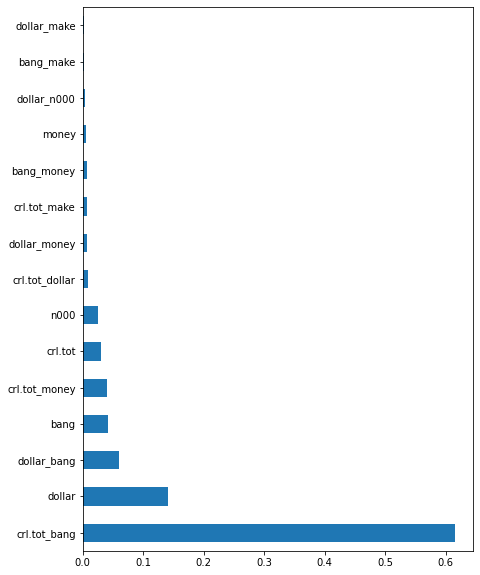

In [36]:
plt.rcParams['figure.figsize'] = (7,10)
feat_importances = pd.Series(gbc.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Теперь перейдем к подбору параметров в модели. Для этого в библиотеке *scikit-learn* есть метод *GridSearchCV*. Ему на вход подается модель, список параметров и способ оценивания. При запуске метода *fit* модель обучается со всеми возможными комбинациями параметров, лучшей комбинацией параметров становятся та, при которой значение метрики максимально.

Укажите в качестве *estimator* градиетный бустинг с параметрами по дефолту и <code>random_state=42</code>. В параметре *scoring* укажите <code>'accuracy', n_jobs=-1, cv=5</code>.

Сетку параметров задайте такой:

In [37]:
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}

В ответе укажите точность, округленную до трёх знаков после точки разделителя, для лучших параметров на кросс-валидации.

In [46]:
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(gbc, param_grid, 
                          scoring='accuracy', 
                          n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'learning_rate': 0.01, 'n_estimators': 1250}

In [49]:
round(gridsearch.best_score_, 3)

0.884

Теперь воспользуемся *GridSearchCV* для подбора максимальной глубины (<code>max_depth</code>). В качестве estimator используйте градиентный бустинг с раннеее подобранными параметрами и <code>random_state=42</code>. Переберите все значения <code>max_depth</code> от 5 до 15 включительно. В ответ запишите значение параметра, при котором точность максимальна.

In [53]:
reg_gbc = GradientBoostingClassifier(random_state=42, 
                                     learning_rate=0.01, 
                                     n_estimators=1250)
param_grid = {'max_depth':[i for i in range(5, 16)]}
gridsearch = GridSearchCV(reg_gbc, param_grid, 
                          scoring='accuracy', 
                          n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'max_depth': 5}

Может показаться, что, научившись запускать готовые фукнции из библиотек и настраивать параметры, мы абсолютно готовы к работе. Однако на поле боя нас могут подстерегать еще опасности — *legacy code*, то есть код, написанный кем-то до вас. Может быть, его можно было бы и улучшить, но на нём уже столько всего надстроено, что переписывать всё практически невозможно.

А ещё часто будет возникать необходимость просто понять код коллеги или сделать *code review* (грубо говоря, это анализ кода на предмет ошибок и расхождения в стиле). Во всех этих ситуациях необходим навык быcтрого чтения кода.

Поэтому в качестве примера в этом задании мы предлагаем изучить код для реализации *AdaBoost* с нуля. Вам необходимо запустить эту функцию, но с дописанными строчками (вычисление ошибки и веса алгоритма) на всех признаках, получившихся после всех преобразований в предыдущем датасете (до разделения выборки на обучающую и тестовую). Параметр *learning_rate* возьмите равным 0.001, М = 10. В ответ запишите точность, округленную до трёх знаков после точки-разделителя.

In [59]:
def AdaBoost_scratch(X,y, M=10, learning_rate=1):
    # инициалиазция служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    # инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # цикл по длине М
    for m in range(M):   

        # обучим базовую модель и получим предсказание
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = (y_predict != y)

        # Оцениваем ошибку
        estimator_error = sample_weight[incorrect].sum()
        
        # Вычисляем вес нового алгоритма
        estimator_weight = learning_rate * np.log((1 - estimator_error) / estimator_error)

        # Получаем новые веса объектов
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        # Сохраяем результаты данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    # Для удобства переведем в numpy.array   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получим предсказания
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', round((preds == y).sum() / N, 3)) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X, y, M=10, learning_rate=0.001)

Accuracy =  0.823


[К содержанию](#0)

---

# Стекинг<a name="5"></a>

<b><span style="color:green">Стекинг (stacking)</span></b> — агрегация ответов моделей машинного обучения при помощи ещё одной модели машинного обучения. Подход использует понятие <b><span style="color:green">базовых моделей</span></b>, каждая из которых обучается независимо от остальных, и <b><span style="color:green">мета-модели</span></b>, которая использует предсказания базовых моделей как признаки.

<b><span style="color:green">Правила стекинга:</span></b>  

* Обучать мета-модели нужно на новых для базовых моделей данных. Так избегается <b><span style="color:green">data leak</span></b>, появляющийся при оценке алгоритмов на обучающей выборке.
* Можно использовать подходы из <b><span style="color:green">кросс-валидации</span></b> (разбиение по фолдам, бутстрап) для получения различных моделей.
* Лучше применять <b><span style="color:green">регрессоры</span></b> для мета-моделей.
* Для старта лучше взять простую мета-модель, например, линейную регрессию. В случае классификации — для агрегации вероятности классов. Этот частный случай называют <b><span style="color:green">блендингом</span></b> (blending).
* Брать в качестве базовых моделей модели различной природы.
* Обучать модель не только на истинный таргет, но и на <b><span style="color:green">прокси таргет</span></b>, например, на важный признак, который выявили во время исследования данных.
* Делать стекинг с большим количеством <b><span style="color:green">уровней</span></b> при наличии достаточного количества данных, времени и усилий, что на практике редко.

[К содержанию](#0)

---

# Стекинг. Практика<a name="6"></a>

Разберём стекинг на практике, проанализировав датасет, описывающий параметры, которые были сняты со спутника при фотографировании Земли. У нас есть 54 переменные. Для упрощения будем рассматривать два типа поверхностей — так мы сводим нашу задачу к <b><span style="color:green">задаче бинарной классификации</span></b>. Сделаем базовую предобработку, воспользуемся <b><span style="color:green">StandardScaler</span></b>.

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

In [61]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', sep=',', header=None)[:10000]

In [62]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2


In [63]:
df.shape

(10000, 55)

In [64]:
features = list(range(0, 54))
target = 54

df = df[(df[target] == 1) | (df[target] == 2)]

In [65]:
cover_train, cover_test = train_test_split(df, test_size=0.5)

cover_X_train, cover_y_train = cover_train[features], cover_train[target]
cover_X_test, cover_y_test = cover_test[features], cover_test[target]

In [66]:
scaler = StandardScaler()
cover_X_train = scaler.fit_transform(cover_X_train)
cover_X_test = scaler.transform(cover_X_test)

Stacking — еще один способ объединить несколько алгоритмов в один, который часто используется как в решении реальных задач из промышленной сферы, так и в конкурсах на платформах вроде Kaggle.  
Подход использует понятие _базовых классификаторов_, каждый из которых независимо обучается на некотором (возможно одном и том же) множестве признаков, а также _мета-классификатора_, использующего предсказания базовых классификаторов как признаки.

Для избежания переобучения будем разбивать обучающую выборку на фолды.  
Например, фолды при разбиении на три части:  
``==*``  
``=*=``  
``*==``  

Это требуется для того, чтобы получить новые признаки (ответы алгоритмов на первом уровне) на всей обучающей выборке, т.е. ответы алгоритма на тех объектах, которые не были использованы во время обучения. В примере выше мы будем использовать ответы алгоритма, полученные на объектах звездочках. _Важно_: на каждом фолде мы обучаем алгоритм заново.

In [67]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the classifier.
    
    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

In [68]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [69]:
np.random.seed(42)

In [70]:
clf = GradientBoostingClassifier(n_estimators=300)
clf.fit(cover_X_train, cover_y_train)

accuracy_score(clf.predict(cover_X_test), cover_y_test)

0.773784355179704

In [71]:
cv = KFold(n_splits=10, shuffle=True)

stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(C=0.001, penalty='l1', solver='liblinear', max_iter=5000),
    LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=5000),  
    RandomForestClassifier(n_estimators=300, n_jobs=-1),
    GradientBoostingClassifier(n_estimators=300)
], cover_X_train, cover_X_test, cover_y_train.values, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.63s/it]


In [72]:
total_features_train = np.hstack([cover_X_train, stacked_features_train])
total_features_test = np.hstack([cover_X_test, stacked_features_test])

In [73]:
np.random.seed(42)
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, cover_y_train)
accuracy_score(clf.predict(stacked_features_test), cover_y_test)

0.7871740662438337

### ЗАДАЧИ

In [83]:
import pandas as pd
import numpy as np

from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.datasets import load_digits

from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint

In [84]:
dataset = load_digits()
X, y = dataset['data'], dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

В скринкасте мы разобрали схему генерации признаков в стекинге, когда для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке. Реализуйте схему, когда вместо этого производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения.

___Логика решения:___  

1. Создадим <code>X_meta_test</code>, заполним его нулями (по аналогии с <code>X_meta_train</code>);  

2. Далее на каждом шаге, где мы обучаем <code>folded_clf.fit (X_fold_train, y_fold_train)</code> и его предсказания на <code>X_fold_predict</code> запихиваем в <code>X_meta_train[predict_fold_index]</code> добавим еще одну строку, где в <code>X_meta_test</code> будем добавлять предсказания вероятностей <code>folded_clf</code> на <code>X_test</code>. Их можно сразу складывать друг с другом или сохранить много массивов, тогда в конце их нужно будет все сложить, а потом делить на количество сплитов (количество массивов равно количеству сплитов в кросс - валидации);  

3. После цикла останется только усреднить все эти массивы, это и будет наш <code>X_meta_test</code>.

In [75]:
def compute_meta_feature_mean(clf, X_train, X_test, y_train, cv):
    """    
    Эта функция подсчитывает признаки для мета-классификатора.     
    Они являются вероятностями классов при решении задачи 
    многоклассовой классификации.    
    :arg clf: классификатор    
    :args X_train, y_train: обучающая выборка    
    :arg X_test: признаки тестовой выборки    
    :arg cv: класс, генерирующий фолды (KFold)    
    :returns X_meta_train, X_meta_test: новые признаки для 
    обучающей и тестовой выборок    
    """
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    
    X_meta_tests_array = []
    splits = 0
    for train_fold_index, predict_fold_index in cv.split(X_train):
        n_classes = len(np.unique(y_test))
        X_meta_test = np.zeros((len(X_test), n_classes), dtype=np.float32)
        splits += 1
        
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
        X_meta_tests_array.append(folded_clf.predict_proba(X_test))

    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)

    X_meta_test = sum(X_meta_tests_array) / splits

    return X_meta_train, X_meta_test

Для следующих заданий используйте этот код:

In [105]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [77]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [78]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

Используйте функцию __generate_meta_features__ для стекинга следующих алгоритмов:  
* логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимое количество итераций — 2000
* логистическая регрессия с L2-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — multinomial, максимальное допустимое количество итераций — 2000
* случайный лес из 300 деревьев
* градиентный бустинг из 200 деревьев


Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — __auto__ и солвером __'lbfgs'__.  
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [87]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [85]:
stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(C=0.001, 
                       penalty='l1', 
                       solver='saga', 
                       multi_class='ovr',
                       max_iter=2000, random_state=42),
    LogisticRegression(C=0.001, 
                       penalty='l2', 
                       solver='saga', 
                       multi_class='multinomial', 
                       max_iter=2000, random_state=42),  
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    GradientBoostingClassifier(n_estimators=200, random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:19<00:00, 34.95s/it]


In [86]:
clf = LogisticRegression(penalty='none', 
                         solver='lbfgs', 
                         multi_class='auto', 
                         random_state=42)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.978096


Используйте функцию __generate_meta_features__ для стекинга следующих алгоритмов:  

* случайный лес из 300 деревьев
* случайный лес из 200 экстремальных деревьев


Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — __auto__ и солвером __'lbfgs'__.  
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [88]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [89]:
stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.64s/it]


In [90]:
clf = LogisticRegression(penalty='none', 
                         solver='lbfgs', 
                         multi_class='auto', 
                         random_state=42)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.982421


Используйте функцию __generate_meta_features__ для стекинга следующих алгоритмов:  

* метод ближайшего соседа (k-NN) со стандартными параметрами
* случайный лес из 300 экстремальных деревьев


Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — __auto__ и солвером __'lbfgs'__.  
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [95]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [96]:
stacked_features_train, stacked_features_test = generate_meta_features([
    KNeighborsClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


In [97]:
clf = LogisticRegression(penalty='none', 
                         solver='lbfgs', 
                         multi_class='auto', 
                         random_state=42)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.989904


Используйте функцию __generate_meta_features__ для стекинга следующих алгоритмов:  

* логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимоей количество итераций — 2000
* метод ближайшего соседа со стандартными параметрами
* случайный лес из 300 экстремальных деревьев
* AdaBoost со стандартными параметрами 

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — __auto__ и солвером __'lbfgs'__.  
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [98]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [99]:
stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(C=0.001, 
                       penalty='l1', 
                       solver='saga', 
                       multi_class='ovr',
                       max_iter=2000, random_state=42),
    KNeighborsClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=42),
    AdaBoostClassifier(random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:35<00:00,  8.93s/it]


In [100]:
clf = LogisticRegression(penalty='none', 
                         solver='lbfgs', 
                         multi_class='auto', 
                         random_state=42)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.987201


Используйте функцию __generate_meta_features__ для стекинга следующих алгоритмов:  

* случайный лес из 300 деревьев
* случайный лес из 300 экстремальных деревьев

Для генерации фолдов используйте класс __StratifiedKFold__, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов). Для корректной работы необходимо подправить код в функции __compute_meta_feature__.  

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — __auto__ и солвером __'lbfgs'__.  
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [106]:
def compute_meta_feature_str(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train, y_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [107]:
def generate_meta_features_str(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature_str(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [114]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [115]:
stacked_features_train, stacked_features_test = generate_meta_features_str([
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.29s/it]


In [116]:
clf = LogisticRegression(penalty='none', 
                         solver='lbfgs', 
                         multi_class='auto', 
                         random_state=42)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.983918


Измените 10 фолдов на 20. Укажите полученное качество.

In [117]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

In [118]:
stacked_features_train, stacked_features_test = generate_meta_features_str([
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.20s/it]


In [119]:
clf = LogisticRegression(penalty='none', 
                         solver='lbfgs', 
                         multi_class='auto', 
                         random_state=42)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.984228


Укажите количество фолдов равным 5 и поменяйте мета-алгоритм на случайный лес со стандартными параметрами. Укажите полученное качество.

In [120]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [121]:
stacked_features_train, stacked_features_test = generate_meta_features_str([
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


In [122]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.981661


Поменяйте мета-алгоритм на метод ближайших соседей (k-NN) со стандартными параметрами. Укажите полученное качество.

In [123]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [124]:
stacked_features_train, stacked_features_test = generate_meta_features_str([
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


In [125]:
clf = KNeighborsClassifier(n_jobs=-1)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.98417


Поменяйте мета-алгоритм на градиентный бустинг со стандартными параметрами. Укажите полученное качество.

In [126]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [127]:
stacked_features_train, stacked_features_test = generate_meta_features_str([
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


In [128]:
clf = GradientBoostingClassifier(random_state=42)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.984925


Используйте функцию __generate_meta_features__ для стекинга следующих алгоритмов:  

* случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
* случайный лес из 300 экстремальных деревьев

Для генерации фолдов используйте класс __StratifiedKFold__, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов). Для корректной работы необходимо подправить код в функции __compute_meta_feature__. Выполните разбиение на 3 фолда. 

Как мета-алгортм используйте случайный лес из 100 экстремальных деревьев.  
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [129]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [130]:
stacked_features_train, stacked_features_test = generate_meta_features_str([
    RandomForestClassifier(n_estimators=300, 
                           criterion='gini', 
                           max_depth=24, 
                           n_jobs=-1, 
                           random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)
], X_train, X_test, y_train, cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


In [131]:
clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)
f1 = compute_metric(clf, X_train=stacked_features_train, 
                    y_train=y_train, X_test=stacked_features_test)
print(f1)

0.986498


Обучите на тренировочной выборке следующие алгоритмы:  

* случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
* случайный лес из 300 экстремальных деревьев
* логистическую регрессию со стандартными параметрами  

Усредните их ответы на тестовой выборке методом сложения предсказаний и затем взятия функции __argmax: answer = (prediction1 + prediction2 + prediction3).argmax(axis = 1)__.
Посчитайте качество, аналогично функции __compute_metric (F1-score с макро-усреднением, округленный до 6 знака).__

In [132]:
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [133]:
rfc = RandomForestClassifier(n_estimators=300, 
                           criterion='gini', 
                           max_depth=24, 
                           n_jobs=-1, 
                           random_state=42)
etc = ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)
log = LogisticRegression(random_state=42)
models_lst = [rfc, etc, log]

In [137]:
pred_lst = []
for model in models_lst:
    model.fit(X_train, y_train)
    predict = model.predict_proba(X_test)
    pred_lst.append(predict)
answer = (sum(pred_lst)).argmax(axis = 1)

In [138]:
np.round(f1_score(y_test, answer, average='macro'), 6)

0.976259

[К содержанию](#0)